In [35]:
!pip install tensorflow

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.1584 - loss: 1.6077 - val_accuracy: 0.4091 - val_loss: 1.5802
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.4014 - loss: 1.5724 - val_accuracy: 0.3182 - val_loss: 1.4897
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3059 - loss: 1.4712 - val_accuracy: 0.3182 - val_loss: 1.4515
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.2814 - loss: 1.4555 - val_accuracy: 0.5000 - val_loss: 1.3538
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5472 - loss: 1.3184 - val_accuracy: 0.5455 - val_loss: 1.3799
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5616 - loss: 1.2961 - val_accuracy: 0.5000 - val_loss: 1.2578
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4935 - loss: 1.2119 - val_accuracy: 0.5000 - val_loss: 1.2503
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5464 - loss: 1.1284 - val_accuracy: 0.5455 - val_loss: 1.0968
Epoch 9/20

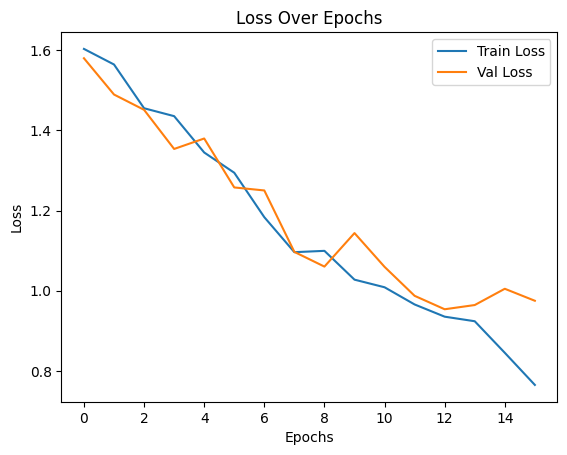

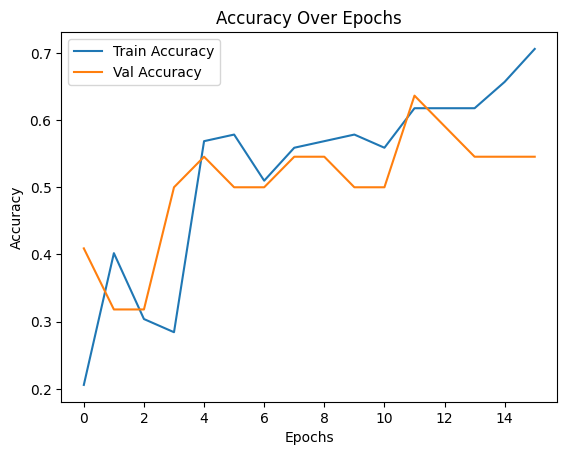

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


# Load dataset
df = pd.read_csv("3) Sentiment dataset.csv")

# Keep top 5 classes
top_labels = df['Sentiment'].value_counts().nlargest(5).index
df = df[df['Sentiment'].isin(top_labels)]

# Label encode
le = LabelEncoder()
df['label'] = le.fit_transform(df['Sentiment'])

# Tokenization
texts = df['Text'].astype(str).tolist()
labels = df['label'].tolist()
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_len = max(len(x) for x in sequences)
X = pad_sequences(sequences, maxlen=max_len)
y = to_categorical(labels)

# Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Model
vocab_size = len(tokenizer.word_index) + 1
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y.shape[1], activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, callbacks=[early_stop])

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [41]:
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Get only the classes that actually appear in y_test
present_labels = np.unique(y_true)
present_class_names = le.inverse_transform(present_labels)

print(classification_report(y_true, y_pred, labels=present_labels, target_names=present_class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
              precision    recall  f1-score   support

 Excitement        0.50      0.25      0.33         4
      Happy        0.00      0.00      0.00         5
        Joy        0.40      1.00      0.57         4
  Positive         0.90      1.00      0.95         9

    accuracy                           0.64        22
   macro avg       0.45      0.56      0.46        22
weighted avg       0.53      0.64      0.55        22



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


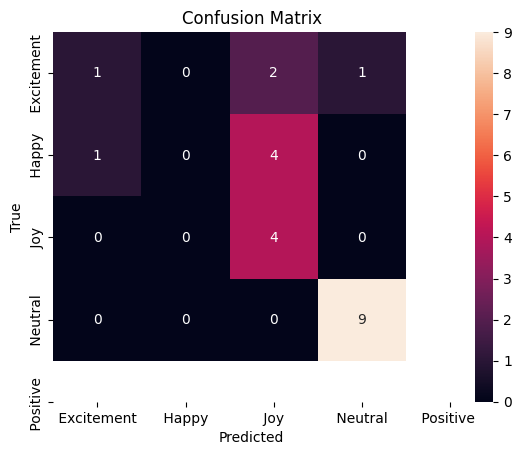

In [42]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, xticklabels=le.classes_, yticklabels=le.classes_, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [43]:
from sklearn.utils import class_weight

y_int = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_int), y=y_int)
class_weights = dict(enumerate(class_weights))

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weights
)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.6690 - loss: 1.1777 - val_accuracy: 0.5000 - val_loss: 0.9700
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6659 - loss: 1.1600 - val_accuracy: 0.6364 - val_loss: 1.0331
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8312 - loss: 0.8736 - val_accuracy: 0.5000 - val_loss: 1.0066
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7243 - loss: 0.9232 - val_accuracy: 0.5455 - val_loss: 0.9729


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Classification Report:
               precision    recall  f1-score   support

 Excitement        0.00      0.00      0.00         4
      Happy        0.00      0.00      0.00         5
        Joy        0.33      1.00      0.50         4
  Positive         0.90      1.00      0.95         9

    accuracy                           0.59        22
   macro avg       0.31      0.50      0.36        22
weighted avg       0.43      0.59      0.48        22



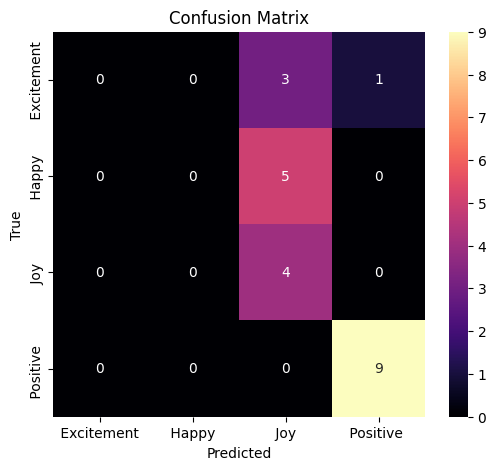

In [45]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Get correct label names
true_labels = np.unique(y_true)
target_names = le.inverse_transform(true_labels)

# Classification report
report = classification_report(y_true, y_pred, target_names=target_names, zero_division=0)
print("Classification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()